## Data visualisation

In [131]:
from importlib import reload
import datakit
reload(datakit)
from datakit import *
import os
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn.linear_model import Lasso
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Load data

In [3]:
df = concat_csv_files()
df = remove_duplicates(df)
df = scrub_data(df)

In [4]:
df.sample(5).head(5)

,rent_price,area,room_num,floor,building_type,extra_space,advertiser_type,students_allowed,elevator,parking_space,year_of_construction,latitude,longitude,approximate_coordinates,district,subway_distance,center_distance,is_furnished,dishwasher,air_conditioning,for_renovation,building_height
5498,3500.0,39.40,2,3.0,blok,balkon,biuro nieruchomości,0,1,1,2014.0,52.195762,20.951672,0,Wlochy,4.093,5.590,1,1,0,0,4.0
7447,3900.0,35.00,2,5.0,apartamentowiec,NaN,prywatny,0,0,0,2023.0,52.184877,21.012022,0,Mokotow,0.610,4.984,0,1,0,0,7.0
1531,6207.6,51.73,3,1.0,kamienica,balkon,biuro nieruchomości,0,1,0,NaN,52.224721,21.012379,0,Srodmiescie,0.656,0.554,1,1,1,0,5.0
8630,2800.0,31.40,1,6.0,blok,NaN,biuro nieruchomości,0,1,0,1974.0,52.274555,21.056114,0,Targowek,0.722,5.815,0,1,0,0,10.0
9133,12000.0,116.00,4,1.0,apartamentowiec,ogródek,biuro nieruchomości,0,1,1,2014.0,52.175014,21.044433,0,Mokotow,1.565,6.465,0,0,1,0,6.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 10549
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rent_price               9999 non-null   float64
 1   area                     9999 non-null   float64
 2   room_num                 9999 non-null   int32  
 3   floor                    9668 non-null   float64
 4   building_type            8032 non-null   object 
 5   extra_space              7056 non-null   object 
 6   advertiser_type          9999 non-null   object 
 7   students_allowed         9999 non-null   int32  
 8   elevator                 9999 non-null   int32  
 9   parking_space            9999 non-null   int32  
 10  year_of_construction     7123 non-null   float64
 11  latitude                 9999 non-null   float64
 12  longitude                9999 non-null   float64
 13  approximate_coordinates  9999 non-null   int32  
 14  district                 999

### Data split

In [77]:
y_col = 'rent_price'
x_cols = [col for col in df.columns if col != y_col]

x_train, x_test, y, y_test = train_test_split(
    df[x_cols], df[y_col], test_size=0.2, random_state=42)

### Data Adjustments

In [80]:
x_train = modeling_preprocessing(x_train)
x_test = modeling_preprocessing(x_test)

### Variable Selection

__Mutual information:__

In [86]:
x_train

,area,room_num,floor,students_allowed,elevator,parking_space,approximate_coordinates,subway_distance,center_distance,is_furnished,dishwasher,air_conditioning,for_renovation,building_height,bt_apartment,bt_tenement,bt_other,at_agency,at_developer,balcony,terrace,garden,cy_old_building,cy_new_building,district_Bemowo,district_Bialoleka,district_Bielany,district_Ochota,district_Praga_Polnoc,district_Praga_Poludnie,district_Rembertow,district_Srodmiescie,district_Targowek,district_Ursus,district_Ursynow,district_Wawer,district_Wesola,district_Wilanow,district_Wlochy,district_Wola,district_Zoliborz
9570,129.4,3,8.0,0,1,0,0,0.989,1.402,1,1,0,0,8.0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1574,40.0,2,1.0,0,1,1,0,2.832,8.834,1,1,1,0,5.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1685,30.0,2,4.0,0,1,0,0,1.613,6.781,1,0,0,0,8.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6354,20.0,1,5.0,0,1,0,0,0.969,3.791,1,0,0,0,15.0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7621,36.0,2,5.0,0,1,1,0,0.534,7.035,1,1,0,0,7.0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,170.0,4,1.0,0,1,1,0,4.929,10.337,0,0,0,0,3.0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5458,75.0,4,2.0,0,1,1,0,3.984,7.214,1,0,0,0,5.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5657,36.0,1,2.0,0,1,0,0,0.861,3.504,1,0,0,0,6.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
861,39.0,2,1.0,0,0,0,0,2.312,6.062,1,1,0,0,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
mi = mutual_info_regression(x, y)
mi = pd.Series(mi, index=x_train.columns)

prefixes = ('bt', 'at', 'cy', 'district')
mi_means = mi.groupby(lambda x: x.split('_')[0] if x.startswith(prefixes) else x).mean().sort_values(ascending=False)

print(mi_means)

area                       0.719257
room_num                   0.409213
center_distance            0.174858
subway_distance            0.130428
building_height            0.111977
floor                      0.078151
air_conditioning           0.060002
dishwasher                 0.053627
parking_space              0.050073
terrace                    0.041612
balcony                    0.039259
bt                         0.030063
is_furnished               0.028686
students_allowed           0.025786
elevator                   0.020902
at                         0.020171
approximate_coordinates    0.017381
cy                         0.014374
district                   0.010915
for_renovation             0.000000
garden                     0.000000
dtype: float64


__Random Forest Feature Importance:__

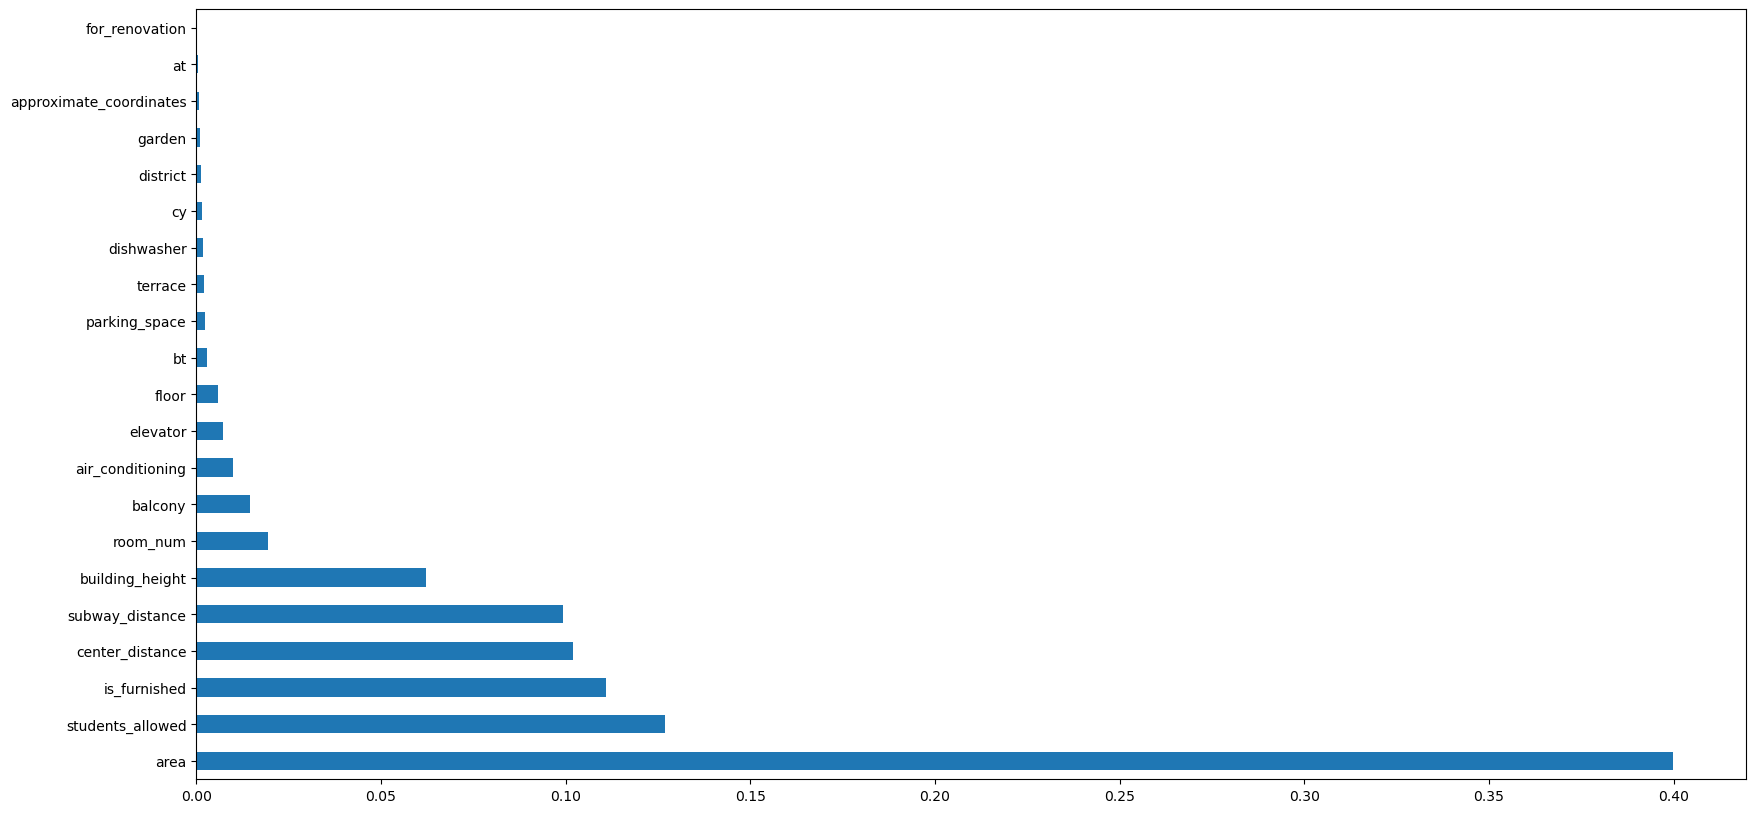

In [102]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y)

plt.rcParams['figure.figsize'] = [20, 10]

feature_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feature_importances_means = feature_importances.groupby(
    lambda x: x.split('_')[0] if x.startswith(prefixes) else x).mean().sort_values(ascending=False)

feature_importances_means.plot(kind='barh')

plt.show()

In [106]:
x_to_drop = ['for_renovation', 'garden']
x_train.drop(x_to_drop, axis=1, inplace=True)
x_test.drop(x_to_drop, axis=1, inplace=True)

### Training models

In [110]:
hyper_store = ['params', 'mean_test_MAE', 'mean_test_MSE', 'mean_test_R2']

scoring = {
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

Random Forest

In [119]:
param_distributions = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "min_samples_split": uniform(0.01, 0.1),
    "min_samples_leaf": uniform(0.01, 0.1),
    "n_jobs": [-1]
}

rf = RandomForestRegressor()

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,
    cv=6,
    scoring= scoring,
    refit='MSE',
    return_train_score=False,
    random_state=42
)

random_search_rf.fit(x_train, y)

results = random_search_rf.cv_results_

hyperparameter_results = pd.DataFrame(results)[hyper_store]

In [120]:
hyperparameter_results.insert(0,'algorithm', 'RandomForest')

XGBoost

In [122]:
param_distributions = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 5),
    "n_jobs": [-1]
}

xg_reg = xgb.XGBRegressor()

random_search_xg = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_distributions,
    n_iter=100,
    cv=6,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    random_state=42
)

random_search_xg.fit(x_train, y)

results_xgb = random_search_xg.cv_results_
results_df_xgb = pd.DataFrame(results_xgb)[hyper_store]
results_df_xgb.insert(0,'algorithm', 'XGBoost')

hyperparameter_results = pd.concat([hyperparameter_results, results_df_xgb], ignore_index=True)

Lasso

In [124]:
param_distributions_lasso = {
    "alpha": uniform(0.0001, 1.0)
}

lasso = Lasso()

random_search_lasso = RandomizedSearchCV(
    estimator=lasso,
    param_distributions=param_distributions_lasso,
    n_iter=100,
    cv=6,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    random_state=42
)

random_search_lasso.fit(x_train, y)

results_lasso = random_search_lasso.cv_results_
results_df_lasso = pd.DataFrame(results_lasso)[hyper_store]
results_df_lasso.insert(0,'algorithm', 'Lasso')

hyperparameter_results = pd.concat([hyperparameter_results, results_df_lasso], ignore_index=True)

In [125]:
sorted_df = hyperparameter_results.sort_values(by=['algorithm', 'mean_test_MSE'], ascending=[True, False])
sorted_df = sorted_df.groupby('algorithm').head(1).reset_index(drop=True)
numeric_cols = sorted_df.select_dtypes(include=[np.number]).columns
sorted_df[numeric_cols] = sorted_df[numeric_cols].abs()
sorted_df

,algorithm,params,mean_test_MAE,mean_test_MSE,mean_test_R2
0,Lasso,{'alpha': 0.9869869366005173},1530.702668,1.309888e+08,0.504035
1,RandomForest,"{'max_depth': 8, 'min_samples_leaf': 0.0107066...",1270.480931,1.287669e+08,0.543806
2,XGBoost,"{'colsample_bytree': 0.9719458022803786, 'gamm...",998.255246,1.279955e+08,0.598024


### Evaluation on out of sample data

In [129]:
results_comparison = {
    'Model': ['RandomForest', 'XGBoost', 'Lasso'],
    'MSE': [],
    'MAE': [],
    'R2': []
}

random_search_objects = [random_search_rf, random_search_xg, random_search_lasso]

for rs in random_search_objects:
    best_model = rs.best_estimator_
    predictions = best_model.predict(x_test)
    
    results_comparison['MSE'].append(mean_squared_error(y_test, predictions))
    results_comparison['MAE'].append(mean_absolute_error(y_test, predictions))
    results_comparison['R2'].append(r2_score(y_test, predictions))

results_df = pd.DataFrame(results_comparison)

results_df

,Model,MSE,MAE,R2
0,RandomForest,3.456105e+06,1049.326428,0.709698
1,XGBoost,1.037040e+07,948.205423,0.128920
2,Lasso,4.356858e+06,1375.869605,0.634038
